# Lab 2 - Diffusion Models

## Introduction

Diffusion models have recently emerged as a new high-performance family of deep generative models. They are incredibly good at a wide range of applications, including image synthesis, video generation, and molecule design.

Diffusion models are a family of probabilistic generative models that gradually degrade data by injecting noise, and then learn to reverse this process to generate new samples. Current research on diffusion models is mainly based on two predominant formulations: denoising diffusion probabilistic models (DDPM), and score-based generative models (SGMs).

In this lab we are going to focus on denoising diffusion models (DDPM) and aims to provide you with an in-depth understanding.

## Denoising Diffusion Probabilistic Models (DDPMs)

DDPMs are an approach to generate new data samples. They work by using two Markov chains (Markov chains are mathematical processes used to model sequences of random variables): a forward chain that adds noise to the data, and a backward chain that turns the noise into data. The goal is to transform the data distribution into a simple distribution (such as a standard Gaussian distribution). This is done using a simple linear Gaussian Markov process. Next, we build a backward Markov chain that learns to reverse the process and generate new data from the noise. Specifically, we first sample a noise vector from the simple distribution, and then apply the backward Markov chain to gradually transform the noise into data.

Training the DDPM involves adjusting the parameters of the backward Markov chain so that it closely matches the inversion of the forward Markov chain. The difference between the two chains is measured using the Kullback-Leibler (KL) divergence and the parameters are adjusted to minimize this difference. This turns out to be a sum of weighted L2 reconstruction losses. In practice it is common to discard the weights and minimize an unweighted sum of reconstruction losses.

### In more detail...

The training process include the following procedure:

1. Define a noise schedule $\{ \beta_{t} \}_{t=1}^T$

2. Sample a batch of training images. For each image in the input batch:

3. Sample a random $t$:

  $
  t \sim \text{Uniform}({1, ..., T})
  $

4. Sample a random Gaussian noise that has the same dimension as the input data:

  $
  \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
  $
        

4.   Add the noise to the clean input using equation:

  $
  x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1-\bar{\alpha}_{t}}\epsilon
  $.


5.   Train the model to learn the noise by minizing the following loss:

  $
  \mathcal{L} = \sum\|\epsilon_\theta(x_t, t) - \epsilon\|^2
  $


The inference process include the following procedure:



1.   Sample a random Gaussian noise that has the same dimension as the input data:

  $
  \epsilon \in \mathcal{N}(\mathbf{0}, \mathbf{I})
  $

2.   Go one step back by the following equations:

  (a) resconstruct $x_0$ from predicted noise $\hat{\epsilon} = \epsilon_\theta(x_t, t)$

  $
  \hat{x}_{0} = \frac{x_{t} - \sqrt{1-\bar{\alpha}_{t}}\hat{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}
  $

  (b) compute posterior of the reconstructed $x_0$

  $
  q(x_{t-1}|x_{t},x_{0}) = \tilde{\mu}_{t}(x_{t},x_{0}) + \sqrt{\tilde{\beta}_{t}}\epsilon
  $

**Question 1:** Which bounds do we need to put on $\beta_{t}$?

**Answer:** Between 0 and 1


**Question 2:** Write the expression of $\bar{\alpha_{t}}$.

**Answer:** Mutplicate Alphas for each s between 1 and t


**Question 3:** Write the expression of $\tilde{\mu}_{t}(x_{t},x_{0})$.

**Answer:** $\sqrt{\bar{\alpha_{t-1}}} \bar{\beta_{t}}/(1 - \bar{\alpha_{t}})X_0$ + $\sqrt{\bar{\alpha_{t}}}(1-\bar{\alpha_{t-1}})/(1 -\bar{\alpha_{t}})X_t$

**Question 4:** Write the expression of $\tilde{\beta}_{t}$.

**Answer:** $(1-\bar{\alpha_{t-1}})/(1 -\bar{\alpha_{t}})\beta_t$

## Tasks to Complete:

1. Generate 2D data

    In this task you are given a 2D dataset call twomoon. The dataset consists of 2D points with coordinates $(x_i, y_i)$. The collection of the points in 2D form a two-moon like shape. (Note that $y$ does not refer to an output or conditioning variable for this data set. It is simply the second coordinate of the 2-dimensional data vector, $\mathbf{x} = [x,y]$).

2. Generate handwritten digits

    In this task we use MNIST dataset. The dataset consists of images of handwritten digits. You are supposed to generate specific digits based on your input via conditional generation
  $.$

## Lets start coding 🤗

Import important libraries that will be used in this lab.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.transforms import Compose, ToTensor, Lambda, Pad
from torchvision.datasets.mnist import MNIST
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import tqdm
import math

## Task 1: Generating 2D data

#### 1. Visualize the dataset:

We will start from simple examples on two dimensional data for you to get familar with diffusion model.
The dataset we employ is two moon dataset, which is defined in library sklearn.datasets.
Run the following code to define the dataset and visualize it.

In [ ]:
def moons_dataset(n=15000):
    X, _ = make_moons(n_samples=n, random_state=42, noise=0.03)
    print(X)
    X[:, 0] = (X[:, 0] + 0.3) * 2 - 1
    X[:, 1] = (X[:, 1] + 0.3) * 3 - 1
    plt.plot(X[:, 0], X[:, 1], 'g.')
    return torch.from_numpy(X.astype(np.float32))
    #return TensorDataset(torch.from_numpy(X.astype(np.float32
    
dataset = moons_dataset(n=8000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

#### 2. Overall Architecture:

For the simple task, a simple Multilayer perceptron (MLP) is employed to define the generative model.
The overal architecture is given below:
The $x$ coordinate, $y$ coordinate, and the $t$ timestep are first passed through *positional embeddings*. The output are concatenated together. *Linear* layers and *GeLUs* (non-linear layers) and residual connections are employed to get the final output.
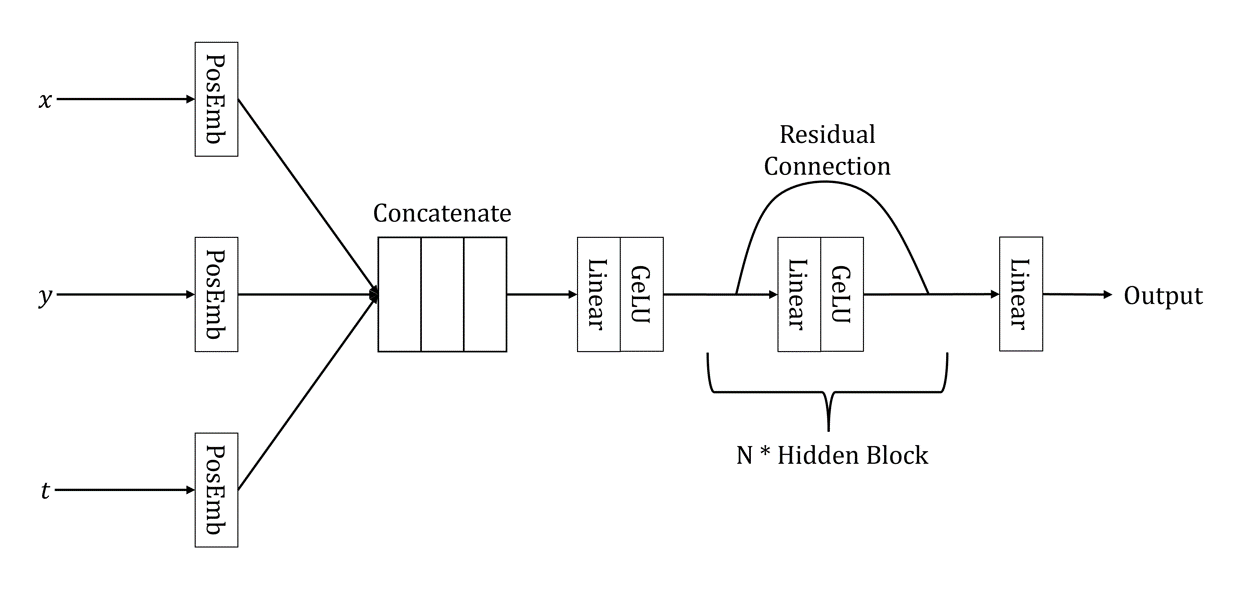

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 scale: int = 25):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size)
        self.input_mlp1 = PositionalEmbedding(emb_size, scale)
        self.input_mlp2 = PositionalEmbedding(emb_size, scale)

        concat_size = self.time_mlp.size + self.input_mlp1.size + self.input_mlp2.size
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1]) #Is this y?
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

#### 3. Construct Denoising Diffusion Probabilistic Model (DDPM)

Now we construct Denoising Diffusion Probabilistic Model (ddpm).

You are supposed to construct important variables and complete several important functions.

*   noiseScheduler: Construct the noise scheduler: $\beta_{0},...,\beta_{T}$.

*   construct variables from $\beta_t$: $\alpha_t$, $\bar{\alpha}_t$, $\bar{\alpha}_{t-1}$, $\sqrt{\bar{\alpha}_{t}}$, $\sqrt{1-\bar{\alpha}_{t}}$, two coeficients to compute $\tilde{\mu}_{t}(x_{t},x_{0})$, two coeficients to compute $\hat{x}_{0}$.

*   add_noise: Add noise to the input data according to the noise scheduler: $x_{t} = \sqrt{\bar{\alpha}_{t}}x_{0} + \sqrt{1-\bar{\alpha}_{t}}\epsilon$.

*   q_posterior: Compute posterior mean: $\tilde{\mu}_{t}(x_t,x_0)$.

*   get_variance: Compute posterior variance: $\tilde{\beta}_{t}$.

*   reconstruct_x0: Compute resconstructed input data from the predicted noise: $\hat{x}_{0} = \frac{x_{t} - \sqrt{1-\bar{\alpha}_{t}}\hat{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}$.

*   sample_timesteps: randomly sample timestep for training the diffusion model: $t \in \text{Uniform}({1, ..., T})$.

*   step: Reverse process for inference (sampling), sample $x_{t-1}$ based on $x_{t}$ and the model output (predicted noise)
$.$

In [ ]:
class ddpm():
    def __init__(self,
                 num_timesteps=50,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule='linear'
                 ):
        # Initialize parameters
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_schedule = beta_schedule

        # Initialize noise scheduler betas
        # this parameter should have a dimension of [num_timesteps]
        self.betas = self.noiseScheduler()

        # parameters alpha, alphas_cumprod, alphas_cumprod_prev
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        # alphas_cumprod is the cumulatetive product of alphas: $\bar{\alpha}_{t}$
        # alphas_cumprod_prev stores a shifted version of alphas_cumprod: $\bar{\alpha}_{t-1}$
        # for alphas_cumprod_prev don't forget to pad 1. for the first element
        self.alphas = [1-beta for beta in self.betas]
        
        self.alphas_cumprod = []
        tmp = 1
        for alpha in self.alphas: 
            tmp = alpha * tmp
            #print(tmp)
            self.alphas_cumprod.append(tmp)
        self.alphas_cumprod_prev = [1] + self.alphas_cumprod[:-1]

        

        # compute parameters required for function self.add_noise
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.sqrt_alphas_cumprod = [math.sqrt(alpha_cumprod) for alpha_cumprod in self.alphas_cumprod]
        self.sqrt_one_minus_alphas_cumprod = [math.sqrt(1 - alpha_cumprod) for alpha_cumprod in self.alphas_cumprod]
        self.sqrt_one_minus_alphas_cumprod = torch.tensor(self.sqrt_one_minus_alphas_cumprod)[:,None]


        # compute parameters required for function self.q_posterior
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.posterior_mean_coef1 = []
        self.posterior_mean_coef2 = []
        for t in range(0, self.num_timesteps):
            tmp2 = self.alphas_cumprod_prev[t]
            sqrt_cumprod_prev = math.sqrt(tmp2)
            tmp = 1 - self.alphas_cumprod[t]
            result = sqrt_cumprod_prev * self.betas[t] / tmp
            self.posterior_mean_coef1.append(result)
            self.posterior_mean_coef2.append(math.sqrt(self.alphas[t]) * (1 - self.alphas_cumprod_prev[t])/(1-self.alphas_cumprod[t]))
        
        # compute parameters required for function self.reconstruct_x0
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.reconstruct_x0_coef1 = [1/sqrt_alphas_cumprod for sqrt_alphas_cumprod in self.sqrt_alphas_cumprod]
        self.reconstruct_x0_coef2 = self.sqrt_one_minus_alphas_cumprod.clone().detach()
        for i in range(0, len(self.reconstruct_x0_coef1)):
            self.reconstruct_x0_coef2[i] = self.reconstruct_x0_coef2[i] * self.reconstruct_x0_coef1[i]

        self.alphas = torch.tensor(self.alphas)
        self.alphas_cumprod = torch.tensor(self.alphas_cumprod)
        self.alphas_cumprod_prev = torch.tensor(self.alphas_cumprod_prev)
        self.sqrt_alphas_cumprod = torch.tensor(self.sqrt_alphas_cumprod)
  
        self.posterior_mean_coef1 = torch.tensor(self.posterior_mean_coef1)
        self.posterior_mean_coef2 = torch.tensor(self.posterior_mean_coef2)
        self.reconstruct_x0_coef1 = torch.tensor(self.reconstruct_x0_coef1)
        #self.reconstruct_x0_coef2 = torch.tensor(self.reconstruct_x0_coef2)

        # expand dimension #Do we need to convert to numpy array here? for lines below to work.
        # Each of this parameters should have dimension of [num_timesteps,1]
        # This is for the following operation so that we don't get a mismatch of dimensions
        print(self.alphas.shape)
        self.alphas = self.alphas[:,None]
        self.alphas_cumprod = self.alphas_cumprod[:,None]
        self.alphas_cumprod_prev = self.alphas_cumprod_prev[:,None]
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod[:,None]
        #self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod[:,None]
        self.posterior_mean_coef1 = self.posterior_mean_coef1[:,None]
        self.posterior_mean_coef2 = self.posterior_mean_coef2[:,None]
        self.reconstruct_x0_coef1 = self.reconstruct_x0_coef1[:,None]
        print(self.alphas.shape)
        print(self.alphas)
        #self.reconstruct_x0_coef2 = self.reconstruct_x0_coef2[:,None]

    # construct noise beta scheduler
    # you are supposed to construct a linear beta scheduler
    # input: number of time steps
    # output: a variable called 'betas' that has a dimension of [num_timesteps]
    # hint: use torch.linspace to construct the one-dimensional tensor beta
    def noiseScheduler(self):
        if self.beta_schedule == "linear":
            betas = torch.tensor([self.beta_start + ((self.beta_end - self.beta_start)/
                                        (self.num_timesteps - 1)) * i for i in range(0, self.num_timesteps)])
        return betas

    # forward process $q(x_{t}|x_{0})$
    # inputs: x_0(input data), noise(random sampled noise), and t(random sampled timestep)
    # output: x_t(noisy data)
    # dimensions:
    # x_0: [batch_size, 1]
    # noise: [batch_size, 1]
    # t: [batch_size]
    # x_t: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def add_noise(self, x_0, noise, t):
        s1 = self.sqrt_alphas_cumprod[t]
        s2 = self.sqrt_one_minus_alphas_cumprod[t]
        return s1 * x_0 + s2 * noise

    # forward process posteriors mean $q(x_{t-1}|x_{t},x_{0})$
    # input: x_0(reconstructed input data), x_t(noisy data from forward process), and t(current timestep)
    # output: mu(posteriors mean)
    # dimensions:
    # x_0: [batch_size, 1]
    # x_t: [batch_size, 1]
    # t: scalar
    # mu: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        mu = s1 * x_0 + s2 * x_t
        return mu

    # forward process posteriors variance $q(x_{t-1}|x_{t},x_{0})$
    # input: t(current timestep)
    # output: variance(posteriors variance)
    # dimensions:
    # t: scalar
    # variance: scalar
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def get_variance(self, t):
        s1 = 1 - self.alphas_cumprod_prev[t]
        s2 = 1 - self.alphas_cumprod[t]
        variance = (s1/s2) * self.betas[t]
        return variance

    # reconstruct input data x_0 according to forward process equation
    # input: x_t(noisy data from forward process), t(current timestep), and pred_noise(predicted noise from model output)
    # output: x_0(reconstructed input data)
    # dimensions:
    # x_t: [batch_size, 1]
    # t: scalar
    # pred_noise: [batch_size, 1]
    # x_0: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def reconstruct_x0(self, x_t, t, pred_noise):
        s1 = self.reconstruct_x0_coef1[t]
        s2 = self.reconstruct_x0_coef2[t]
        return s1 * x_t - s2 * pred_noise

    # sample timesteps for training
    # input: n(batch size)
    # output: randomly sampled integers
    # dimensions:
    # n: scalar
    # output: [batch_size]
    # hint: use torch.randint to select random integers for training
    def sample_timesteps(self, n):
        t = torch.randint(1, self.num_timesteps, (n,))
        return t

    # one step backward during sampling(inference)
    # functions needed: reconstruct_x0, q_posterior, and
    # input: pred_noise(predicted noise from model output), t(current time step), sample(sample from the last step)
    # output: prev_sample
    # dimensions:
    # pred_noise: [batch_size, 1]
    # t: scalar
    # sample: [batch_size, 1]
    # prev_sample: [batch_size, 1] (input to the next loop)
    # hint:
    # 1. resconstruct x_0 from x_t, t, and pred_noise
    # 2. predict the mean of the previous sample, i.e. x_{t-1} by function 'q_posterior'. This function takes the reconstructed x_0, x_t, t as input.
    # 3. predict the variance of the previous sample by function 'get_variance'.
    # 4. Don't forget to set variance to 0 when t==1, which is the last output, and we don't want any noise here.
    def step(self, pred_noise, t, x_t):
        # sample Gaussian noise
        # the noise shoule have the same shape as 'pred_noise'
        noise = torch.randn_like(pred_noise)*self.beta_end
        # reconstruct x_0
        pred_x_0 = self.reconstruct_x0(x_t, t, pred_noise)
        # compute posterior mean
        mean = self.q_posterior(pred_x_0, x_t, t)
        # compute posterior variance (different if t == 0 or if t > 0!)
        if t == 0:
            variance = 0
        if t > 0:
            variance = self.get_variance(t)
        # sample based on posterior and variance
        pred_prev_sample = mean + (variance ** 0.5) * noise

        return pred_prev_sample

**Question 5:** Why do we have to expand the dimension by `[:,None]`? 

**Answer:** To prevent dimension mismatch

**Question 6:** Why is the posterior variance 0 when t == 0? 

**Answer:** We have the original image, no noise has been added

Run the following code to check the parameters.
You should get the numbers: 0.0082, 0.9918, 0.9161, 0.9237, 0.9571, 0.2897, 0.0942, 0.9057, 1.0448, 0.3026

In [ ]:
# test the parameters
diffusion = ddpm()
print(diffusion.betas[20])
print(diffusion.alphas[20])
print(diffusion.alphas_cumprod[20])
print(diffusion.alphas_cumprod_prev[20])
print(diffusion.sqrt_alphas_cumprod[20])
print(diffusion.sqrt_one_minus_alphas_cumprod[20])
print(diffusion.posterior_mean_coef1[20])
print(diffusion.posterior_mean_coef2[20])
print(diffusion.reconstruct_x0_coef1[20])
print(diffusion.reconstruct_x0_coef2[20])

print(alphas.shape)

print("-----------------------------")


#### 4. Training and Sampling

Now we have the model and the ddpm. It's time to train the model and visualize the result.

What you need to do:


*   Initialize the Model

*   Initialize the Denoising Diffusion Model

*   Initialize Optimizer

*   Implement training loop

    Train the model with loss: $\mathcal{L} = \sum\|\epsilon_\theta(x_t, t) - \epsilon\|^2$

    After each training epoch check the sampling quality
$.$

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define Model
model = MLP()

# Initialize Denoising Diffusion Model
diffusion = ddpm()

# Initialize Optimizer
optimizer = torch.optim.AdamW(model.parameters())
save_images_step = 1
num_epochs = 10
eval_batch_size = 1000
print("Training model...")

for epoch in range(num_epochs):
    model.train()
    lbar = tqdm.tqdm(dataloader)
    lbar.set_description(f"Epoch {epoch}")
    for step, input in enumerate(lbar):
        # randomly sample 'noise' that has the same dimension as 'input'
        # hint: you may want to use function 'torch.randn_like'
        noise = torch.randn_like(input)
        # randomly sample timesteps 't' for each input in the batch
        # hint: you may want to use the function 'sample_timesteps' we defined in class ddpm
        # hint: use .shape[0] to get the batch size
        t = diffusion.sample_timesteps(input.shape[0])
        # add noise to the clean input data according to the timesteps 't' we sampled
        # hint: you may want to use the function 'add_noise' we defined in class ddpm
        x_t = diffusion.add_noise(input, noise, t)
        # predict the noise based on the noise input, and the timestep by the MLP we defined
        predicted_noise = model(x_t, t)
        # compute a loss between the randomly sampled noise and the predicted noise
        # hint: you may want to use function F.mse_loss
        loss = F.mse_loss(noise, predicted_noise)
        # complete the rest by .backward(), .step(), .zero_grad()
        ###################
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ###################
    lbar.close()

    if epoch % save_images_step == 0 or epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            # randomly sample 'noise' that has the dimension [eval_batch_size, 2]
            # this will be the starting point of our sampling i.e. x_T
            sample = torch.randn(eval_batch_size, 2)
            timesteps = list(range(diffusion.num_timesteps))[::-1]
            for i in tqdm.tqdm(reversed(range(1, diffusion.num_timesteps)), position= 0):
                t = (torch.ones(eval_batch_size) * i).long()
                # predict the noise based on the noise input, and the timestep by the MLP we defined
                # hint: to predict the noise, the timestep shoule be the same dimension as the input batch, think about whether to use 't' 
                #or 'i' here
                predicted_noise = model(sample, t)
                # given the predicted noise and the current timestep and the current noise image, we are able to step one timestep backward
                # hint: you may want to use the function 'step' we defined in class ddpm
                # hint: the timestep in function 'step' shoule be a scalar, think about whether to use 't' or 'i' here
                sample = diffusion.step(predicted_noise, i, sample)
            xmin, xmax = -6, 6
            ymin, ymax = -6, 6
            fig = plt.figure(figsize=(2, 2))
            plt.scatter(sample[:, 0], sample[:, 1])
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            plt.show()

## Task 2: Generating handwritten digits

#### 1. Visualize the dataset:

We will now try to use diffusion models to generate handwritten digits. Visualize the dataset by running the following code.

In [ ]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

batch_size = 64

transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2),
    Pad([2,2,2,2], fill=-1, padding_mode='constant')]
)
dataset = MNIST("./datasets", download=True, train=True, transform=transform)
dataloader = DataLoader(dataset, batch_size, shuffle=True)


"""
This function plots images in a grid. Input is a Tensor.
See show_first_batch to see how it is used.
"""
def show_images(images, title=""):
    images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(4, 4))
    cols = math.ceil(len(images) ** (1 / 2))
    rows = math.ceil(len(images) / cols)
    for r in range(rows):
        for c in range(cols):
            idx = cols * r + c
            ax = fig.add_subplot(rows, cols, idx + 1)
            ax.axis('off')
            if idx < len(images):
                ax.imshow(images[idx][0], cmap="gray")
    fig.suptitle(title, fontsize=18)
    plt.show()

def show_first_batch(dataloader):
    for batch in dataloader:
        print(batch[0].shape)
        show_images(batch[0], "Images in the first batch")
        break
show_first_batch(dataloader)

#### 2. Overall Architecture:

Now we need a more complicated model for this task.
The U-Net architecture is employed here. However, different from the traditional U-Net, here we need some conditions to ensure we generate the desired digits. Here the condition is a label $y$, that is the number that you want to generate.
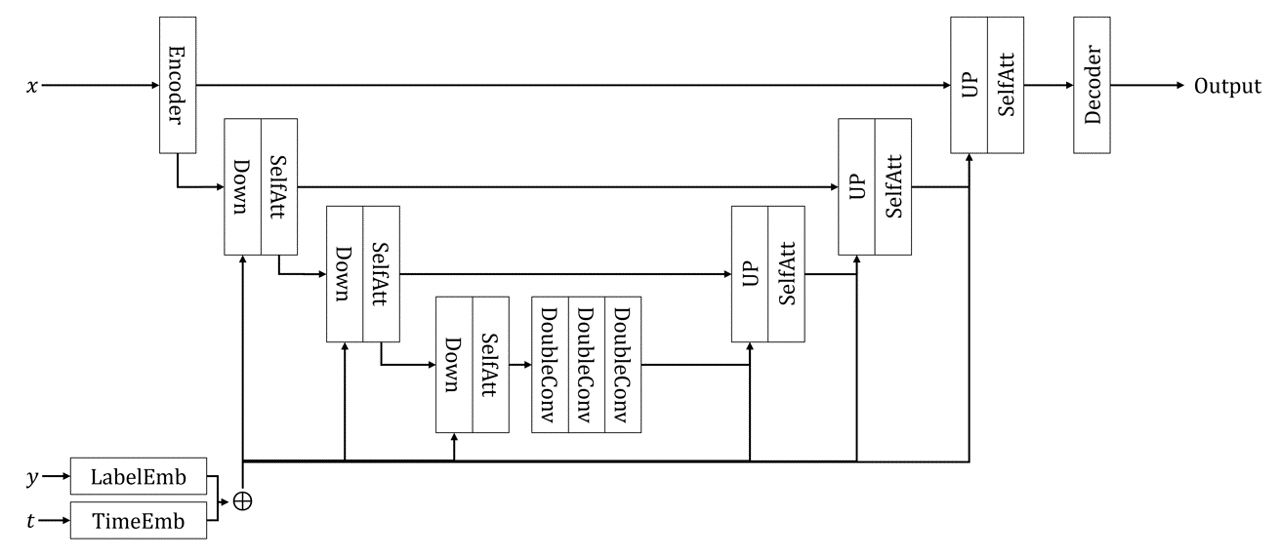

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size)).to(device)
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c, mid_c = None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_c:
            mid_c = out_c
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_c, mid_c, kernel_size = 3, padding = 1, bias=False),
            nn.GroupNorm(1, mid_c),
            nn.GELU(),
            nn.Conv2d(mid_c, out_c, kernel_size = 3, padding = 1, bias=False),
            nn.GroupNorm(1, out_c)
        )
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c,out_c)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_c)
        )
    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[-2],x.shape[-1])
        return x + emb

class Up(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_c, in_c, residual=True),
            DoubleConv(in_c,out_c,in_c//2)
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_c)
        )
    def forward(self, x, skip_x, t):
        x= self.up(x)
        x = torch.cat([skip_x,x],dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[-2],x.shape[-1])
        return x + emb

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super().__init__()
        self.channels, self.size = channels, size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = x.view(-1, self.channels, self.size*self.size).swapaxes(1,2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln,x_ln,x_ln)
        attention_value = attention_value * x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2,1).view(-1, self.channels, self.size, self.size)

class UNet(nn.Module):
    def __init__(self, num_classes=10, time_dim=256):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.time_dim =  time_dim
        self.time_mlp = PositionalEmbedding(256, 1.0).to(self.device)
        self.encoder_input = DoubleConv(1, 64)
        self.encoder_downsample1 = Down(64,128)
        self.encoder_attention1 = SelfAttention(128,16)
        self.encoder_downsample2 = Down(128,256)
        self.encoder_attention2 = SelfAttention(256,8)
        self.encoder_downsample3 = Down(256, 256)
        self.encoder_attention3 = SelfAttention(256, 4)

        self.conv1 = DoubleConv(256,512)
        self.conv2 = DoubleConv(512,512)
        self.conv3 = DoubleConv(512,256)

        self.decoder_upsample1 = Up(512, 128)
        self.decoder_attention1 = SelfAttention(128, 8)
        self.decoder_upsample2 = Up(256, 64)
        self.decoder_attention2 = SelfAttention(64, 16)
        self.decoder_upsample3 = Up(128, 64)
        self.decoder_attention3 = SelfAttention(64, 32)
        self.decoder_output = nn.Conv2d(64, 1, kernel_size = 1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t,y=None):
        t = self.time_mlp(t)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.encoder_input(x)
        x2 = self.encoder_downsample1(x1,t)
        x2 = self.encoder_attention1(x2)
        x3 = self.encoder_downsample2(x2, t)
        x3 = self.encoder_attention2(x3)
        x4 = self.encoder_downsample3(x3, t)
        x4 = self.encoder_attention3(x4)

        x4 = self.conv1(x4)
        x4 = self.conv2(x4)
        x4 = self.conv3(x4)

        x3 = self.decoder_upsample1(x4, x3, t)
        x3 = self.decoder_attention1(x3)
        x2 = self.decoder_upsample2(x3, x2, t)
        x2 = self.decoder_attention2(x2)
        x1 = self.decoder_upsample3(x2, x1, t)
        x = self.decoder_attention3(x1)
        return self.decoder_output(x)


#### 3. Construct Conditional Denoising Diffusion Probabilistic Model (cddpm)

Copy the previous defined ddpm here (some modification is needed).

Make necessary changes:
1. change the num_timesteps to 1000 because now we are generating more complicated images.
2. put self.betas to GPU by `.to(self.device)`.
3. Previously we expand the dimension of the parameters to be the same as the input data by `[:,None]`, now you have to do `[:,None,None,None]` instead.

In [ ]:
class cddpm():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule='linear'
                 ):
        # Initialize parameters
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_schedule = beta_schedule

        # Initialize noise scheduler betas
        # this parameter should have a dimension of [num_timesteps]
        self.betas = self.noiseScheduler().to(self.device)

        # parameters alpha, alphas_cumprod, alphas_cumprod_prev
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        # alphas_cumprod is the cumulative product of alphas: $\bar{\alpha}_{t}$
        # alphas_cumprod_prev stores a shifted version of alphas_cumprod: $\bar{\alpha}_{t-1}$
        # for alphas_cumprod_prev don't forget to pad 1. for the first element
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = self.alphas_cumprod / self.alphas #Check

        # compute parameters required for function self.add_noise
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        # compute parameters required for function self.q_posterior
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.posterior_mean_coef1 = torch.sqrt(self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * self.betas
        self.posterior_mean_coef2 = torch.sqrt(self.alphas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

        # compute parameters required for function self.reconstruct_x0
        # Each of this parameters should have the same dimension as betas [num_timesteps]
        self.reconstruct_x0_coef1 = 1. / torch.sqrt(self.alphas_cumprod)
        self.reconstruct_x0_coef2 = self.reconstruct_x0_coef1 * torch.sqrt(1 - self.alphas_cumprod)

        # expand dimension #Do we need to convert to numpy array here? for lines below to work.
        # Each of this parameters should have dimension of [num_timesteps,1]
        # This is for the following operation so that we don't get a mismatch of dimensions
        self.alphas = self.alphas[:,None, None, None]
        self.alphas_cumprod = self.alphas_cumprod[:,None, None, None]
        self.alphas_cumprod_prev = self.alphas_cumprod_prev[:,None, None, None]
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod[:,None, None, None]
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod[:,None, None, None]
        self.posterior_mean_coef1 = self.posterior_mean_coef1[:,None, None, None]
        self.posterior_mean_coef2 = self.posterior_mean_coef2[:,None, None, None]
        self.reconstruct_x0_coef1 = self.reconstruct_x0_coef1[:,None, None, None]
        self.reconstruct_x0_coef2 = self.reconstruct_x0_coef2[:,None, None, None]

    # construct noise beta scheduler
    # you are supposed to construct a linear beta scheduler
    # input: number of time steps
    # output: a variable called 'betas' that has a dimension of [num_timesteps]
    # hint: use torch.linspace to construct the one-dimensional tensor beta
    def noiseScheduler(self):
        if self.beta_schedule == "linear":
             betas = torch.linspace(self.beta_start, self.beta_end, steps=self.num_timesteps)
        return betas

    # forward process $q(x_{t}|x_{0})$
    # inputs: x_0(input data), noise(random sampled noise), and t(random sampled timestep)
    # output: x_t(noisy data)
    # dimensions:
    # x_0: [batch_size, 1]
    # noise: [batch_size, 1]
    # t: [batch_size]
    # x_t: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def add_noise(self, x_0, noise, t):
        s1 = self.sqrt_alphas_cumprod[t]
        s2 = self.sqrt_one_minus_alphas_cumprod[t]
        return s1 * x_0 + s2 * noise

    # forward process posteriors mean $q(x_{t-1}|x_{t},x_{0})$
    # input: x_0(reconstructed input data), x_t(noisy data from forward process), and t(current timestep)
    # output: mu(posteriors mean)
    # dimensions:
    # x_0: [batch_size, 1]
    # x_t: [batch_size, 1]
    # t: scalar
    # mu: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        mu = s1 * x_0 + s2 * x_t
        return mu

    # forward process posteriors variance $q(x_{t-1}|x_{t},x_{0})$
    # input: t(current timestep)
    # output: variance(posteriors variance)
    # dimensions:
    # t: scalar
    # variance: scalar
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def get_variance(self, t):
        s1 = 1 - self.alphas_cumprod_prev[t]
        s2 = 1 - self.alphas_cumprod[t]
        variance = (s1/s2) * self.betas[t]
        return variance

    # reconstruct input data x_0 according to forward process equation
    # input: x_t(noisy data from forward process), t(current timestep), and pred_noise(predicted noise from model output)
    # output: x_0(reconstructed input data)
    # dimensions:
    # x_t: [batch_size, 1]
    # t: scalar
    # pred_noise: [batch_size, 1]
    # x_0: [batch_size, 1]
    # hint: Think about which equation is implemented here. Make use of the parametera we defined above.
    def reconstruct_x0(self, x_t, t, pred_noise):
        s1 = self.reconstruct_x0_coef1[t]
        s2 = self.reconstruct_x0_coef2[t]
        return s1 * x_t - s2 * pred_noise

    # sample timesteps for training
    # input: n(batch size)
    # output: randomly sampled integers
    # dimensions:
    # n: scalar
    # output: [batch_size]
    # hint: use torch.randint to select random integers for training
    def sample_timesteps(self, n):
        t = torch.randint(0, self.num_timesteps, (n,))
        return t

    # one step backward during sampling(inference)
    # functions needed: reconstruct_x0, q_posterior, and
    # input: pred_noise(predicted noise from model output), t(current time step), sample(sample from the last step)
    # output: prev_sample
    # dimensions:
    # pred_noise: [batch_size, 1]
    # t: scalar
    # sample: [batch_size, 1]
    # prev_sample: [batch_size, 1] (input to the next loop)
    # hint:
    # 1. resconstruct x_0 from x_t, t, and pred_noise
    # 2. predict the mean of the previous sample, i.e. x_{t-1} by function 'q_posterior'. This function takes the reconstructed x_0, x_t, t as input.
    # 3. predict the variance of the previous sample by function 'get_variance'.
    # 4. Don't forget to set variance to 0 when t==1, which is the last output, and we don't want any noise here.
    def step(self, pred_noise, t, x_t):
        # sample Gaussian noise
        # the noise shoule have the same shape as 'pred_noise'
        noise = torch.randn_like(pred_noise)
        # reconstruct x_0
        pred_x_0 = self.reconstruct_x0(x_t, t, pred_noise)
        # compute posterior mean
        mean = self.q_posterior(pred_x_0, x_t, t)
        # compute posterior variance (different if t == 0 or if t > 0!)
        if t == 0:
            variance = 0
        if t > 0:
            variance = self.get_variance(t)
        # sample based on posterior and variance
        pred_prev_sample = mean + (variance ** 0.5) * noise

        return pred_prev_sample

In [ ]:
diffusion = cddpm()
print(diffusion.betas[20])
print(diffusion.alphas[20])
print(diffusion.alphas_cumprod[20])
print(diffusion.alphas_cumprod_prev[20])
print(diffusion.sqrt_alphas_cumprod[20])
print(diffusion.sqrt_one_minus_alphas_cumprod[20])
print(diffusion.posterior_mean_coef1[20])
print(diffusion.posterior_mean_coef2[20])
print(diffusion.reconstruct_x0_coef1[20])
print(diffusion.reconstruct_x0_coef2[20])

#### 4. Training and Sampling

Now we have the model and the cddpm. It's time to train the model and visualize the result.

What you need to do:


*   Initialize the Model, don't forget to put the model on GPU.

*   Initialize the Denoising Diffusion Model

*   Initialize Optimizer

*   Implement training loop

    Train the model with loss: $\mathcal{L} = \sum\|\epsilon_\theta(x_t, t, y) - \epsilon\|^2$

    After each training epoch check the sampling quality
$.$

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define Model and put the model to GPU
model = UNet().to(device)

# Initialize Denoising Diffusion Model
diffusion = cddpm()

# Initialize Optimizer
optimizer = torch.optim.AdamW(model.parameters())

save_images_step = 1
num_epochs = 5
eval_batch_size = 20
img_size = 32 # 32 works better for the UNET
print("Training model...")

# Train
for epoch in range(num_epochs):
    model.train()
    lbar = tqdm.tqdm(dataloader)
    lbar.set_description(f"Epoch {epoch}")
    for i, (images, labels) in enumerate(lbar):
        images, labels = images.to(device), labels.to(device)
        # randomly sample 'noise' that has the same dimension as 'images'
        # hint: you may want to use function 'torch.randn_like'
        noise = torch.randn_like(images)
        # randomly sample timesteps 't' for each image in the batch
        # hint: you may want to use the function 'sample_timesteps' we defined in class cddpm
        # hint: use .shape[0] to get the batch size
        # don't forget to put timesteps 't on GPU
        t = diffusion.sample_timesteps(images.shape[0])
        t = t.to(device)
        # add noise to the clean image according to the timesteps 't' we sampled
        # hint: you may want to use the function 'add_noise' we defined in class cddpm
        x_t = diffusion.add_noise(images, noise, t)
        # predict the noise based on the noise image, the timestep, and the labels by the Unet we defined
        predicted_noise = model(x_t, t, labels)
        # compute a loss between the randomly sampled noise and the predicted noise
        # hint: you may want to use function F.mse_loss
        loss = F.mse_loss(noise, predicted_noise) #Why not cross entrophy loss
        # complete the rest by .backward(), .step(), .zero_grad()
        ###################
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ###################

    lbar.close()

    # Sampling
    if epoch % save_images_step == 0 or epoch == num_epochs - 1:
        model.eval()
        labels = torch.tensor([0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9]).to(device)
        with torch.no_grad():
            # randomly sample 'noise' that has the dimension [eval_batch_size, 1, img_size, img_size]
            noise = torch.randn([eval_batch_size, 1, img_size, img_size]).to(device)
            # this will be the starting point of our sampling i.e. x_T
            # don't forget to put this on the GPU
            sample = torch.randn((eval_batch_size, 1, img_size, img_size)).to(device)
            for i in tqdm.tqdm(reversed(range(1, diffusion.num_timesteps)), position= 0):
                t = (torch.ones(eval_batch_size) * i).long().to(device)
                # predict the noise based on the current noise image, the timestep, and the labels by the Unet we defined
                # hint: to predict the noise, the timestep shoule be the same dimension as the input batch, think about whether to use 't' or 'i' here
                predicted_noise = model(sample, t, labels) 
                # given the predicted noise and the current timestep and the current noise image, we are able to step one timestep backward
                # hint: you may want to use the function 'step' we defined in class cddpm
                # hint: the timestep in function 'step' shoule be a scalar, think about whether to use 't' or 'i' here
                sample = diffusion.step(predicted_noise, i, sample)
            sample = (sample.clamp(-1,1) + 1)/2
            show_images(sample)

**Question7:** Summarize and explain the whole process!

**Answer:** First we created the data needed to train the models, for the first model the two moons dataset was used and for the second numbers. The training for two moons and numbers used different models but overall the code for the different datasets was very similar. First we created all the variables we needed. Then these variables were used to implement different help functions that were needed for training/testing to get the parameters required, the following steps were used to train the model  

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

After that the model was tested and the result was evaluated by comparing noise and predicted noise with a MSE loss function. 

## Reflection:

Developing new technology is often a double-edged sword. Considering the use-case of generation models , what are potential positive and negative impacts to society?

**Your thoughts:** It is possible to use this to impersonate people and make it look like they do inappropriate/illegal things, which could cause large issues. It makes it easier to create things, images, movies, games. 